In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt

In [3]:
#Taking only a small sample of the dataframe, which is originally 681k observations.
df = pd.read_csv('blogtext.csv', parse_dates=['date']).sample(100000, random_state=42)

In [4]:
df.head(7)

,id,gender,age,topic,sign,date,text
240436,1058543,female,24,indUnk,Sagittarius,"02,August,2004",1 Corinthians 5:11 'But now I have wri...
54139,3440336,female,23,Arts,Virgo,"08,July,2004",Having moved to Jersey City nearly a mo...
637911,3546243,female,24,indUnk,Taurus,"02,July,2004","urlLink Hey, Metro! Need To Save..."
61178,3367064,female,26,indUnk,Taurus,"29,July,2004",The most hilarious movie I have s...
314089,3590478,female,34,Technology,Capricorn,"20,April,2004",Short of being attached to the b...
431770,3903897,male,27,Technology,Sagittarius,"24,July,2004","I've completed another application -- AND, ..."
84367,714252,male,25,Technology,Leo,"24,June,2003",Grr Blogger giving me jip. /m...


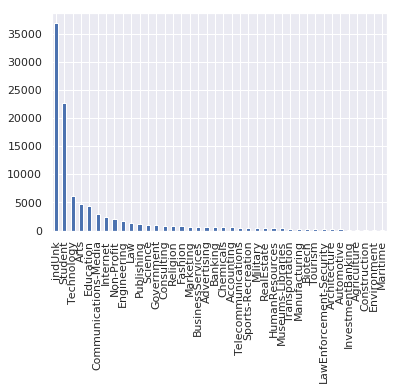

In [5]:
df['topic'].value_counts().plot('bar')

In [8]:
#'test' is the dataframe I'll work with while exploring the data and attempting cleaning/ML techniques.
#I'll remove the "industry unknown" class and the "student" class to give my data some more balance
#The 'student' class is also ambiguous
test = df[df['topic']!='indUnk'][:25000]
test = test[test['topic']!='Student'].copy()
test.head()

,id,gender,age,topic,sign,date,text
54139,3440336,female,23,Arts,Virgo,"08,July,2004",Having moved to Jersey City nearly a mo...
314089,3590478,female,34,Technology,Capricorn,"20,April,2004",Short of being attached to the b...
431770,3903897,male,27,Technology,Sagittarius,"24,July,2004","I've completed another application -- AND, ..."
84367,714252,male,25,Technology,Leo,"24,June,2003",Grr Blogger giving me jip. /m...
124318,1304830,female,14,Education,Libra,"01,July,2003",Everyone look!! v v v v v v v v v Jie...


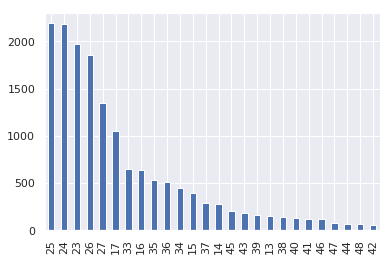

In [9]:
test['age'].value_counts().plot('bar')

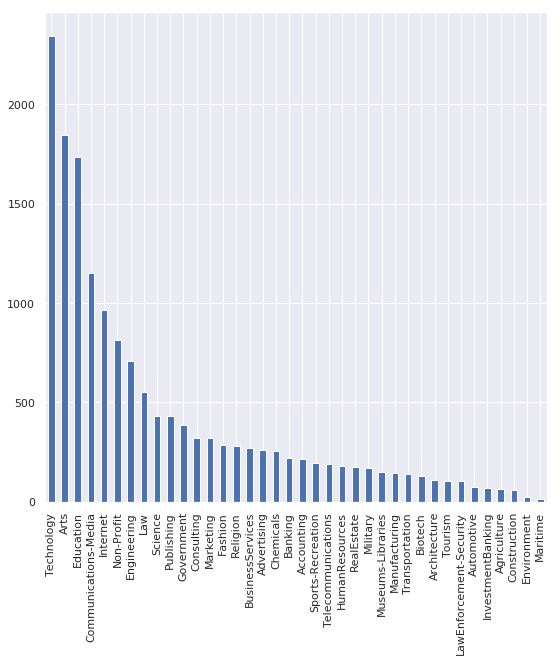

In [10]:
plt.figure(figsize=(9,9))
test['topic'].value_counts().plot('bar')

In [11]:
#Removing all classes but the 20 most populous.
most_pop = list(test.groupby('topic')['topic'].agg('count').sort_values(ascending=False)[:20].index)
test = test[test['topic'].isin(most_pop)]

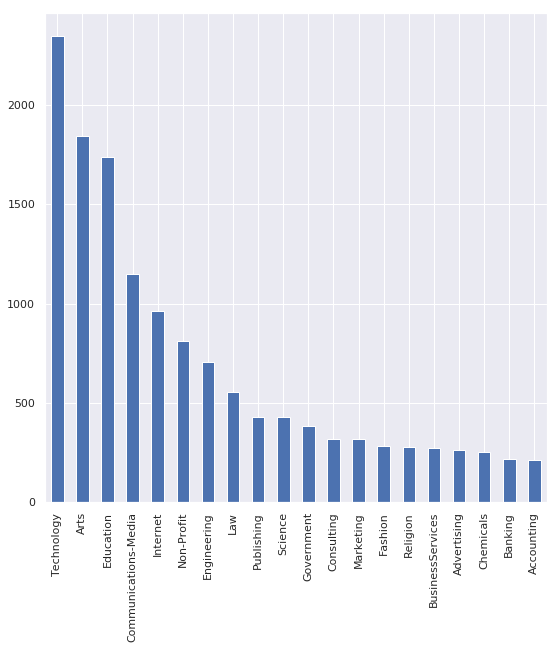

In [12]:
plt.figure(figsize=(9,9))
test['topic'].value_counts().plot('bar')
#So we have imbalanced classes, but not so much that we can't manage it.

In [13]:
test.shape

(13773, 7)

In [14]:
test.groupby('topic')['age'].agg('median').sort_values(ascending=True)

topic
Non-Profit              23
Advertising             24
Arts                    24
Chemicals               24
Accounting              25
Science                 25
Education               25
Engineering             25
Communications-Media    25
BusinessServices        25
Banking                 25
Consulting              25
Government              26
Internet                26
Law                     26
Marketing               26
Publishing              26
Technology              26
Religion                27
Fashion                 36
Name: age, dtype: int64

# Now to clean up the blogposts

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
from nltk.stem import WordNetLemmatizer 
stop_words = set(stopwords.words('english')+["can't","got", "urllink", "nbsp", "one", "like", "thing"]) 
lemmatizer = WordNetLemmatizer() 

def stop_lems(lst):
    '''Remove stopwords and lemmatize the words'''
    filtered = [w.lower() for w in lst if w not in stop_words]
    lemmatized_output = [lemmatizer.lemmatize(w) for w in filtered]
    return lemmatized_output

In [16]:
test['formatted']=test['text'].map(lambda x: tokenizer.tokenize(x))
test['formatted']=test['formatted'].map(lambda x: stop_lems(x))
#This takes forever.

In [19]:
for lst in test['formatted']:
    if 'nbsp' in lst:
        lst.remove('nbsp')
    if 'urllink' in lst:
        lst.remove('urllink')
    if 'got' in lst:
        lst.remove('got')
    if '&nbsp;' in lst:
        lst.remove('&nbsp;')
#     if ''
test['formattedstr'] = test['formatted'].str.join(' ')
test['formattedstr'] = test['formattedstr'].map(lambda x: x.replace('nbsp', '').replace('urllink', '').replace('&nbsp', ''))

In [20]:
from nltk.probability import FreqDist
corp = []
for r in test['formatted']:
    corp.append(r)
text = []
for i in corp:
    text.append(str(i).lower())
fdist = FreqDist(text)
fdist.most_common
words = FreqDist(text)
words.most_common
#What

<bound method Counter.most_common of FreqDist({'[]': 113, "['test']": 4, "['...']": 3, "['audio', 'post', 'powered', 'urllink', 'audblog']": 3, "['i', 'sipping', '3', '1', 'milo', ',', 'dipping', 'soda', 'cracker', 'really', 'yummy', '.', 'i', 'guess', 'drinking', 'milo', '20', 'year', ',', 'could', 'say', 'cant', 'live', 'without', '.', 'recall', 'back', '4', 'year', 'melbourne', ',', '3', '1', 'milo', 'selling', 'wrong', ',', 'could', 'remember', 'try', 'hide', '3', '1', 'big', 'luggage', 'bag', 'everytime', 'fly', 'despite', 'knew', 'prohibited', 'bring', 'au', '.', 'i', 'wana', 'try', 'luck', ',', 'coz', 'good', 'custom', 'dont', 'confiscate', '.', 'i', 'know', 'small', 'amount', '3', '1', 'wont', 'last', 'long', ',', 'jz', 'love', '...', 'dont', 'au', 'milo', ',', 'taste', 'little', 'weird', '....']": 3, '[\'didn\', "\'t", \'get\', \'kicked\', "\'t", \'blog\', \'enough\', \'?\']': 2, "['caitlyn']": 2, "['the', 'mandarin']": 2, '[\'this\', \'celebrity\', \'blog\', \'i\', \'blogging

In [21]:
# test['formatted'][16].remove('urllink')
test['formattedstr'].head()

54139     having moved jersey city nearly month ago , i ...
314089    short attached bumper pickup truck cock ring d...
431770    i 've completed another application -- and , i...
84367     grr blogger giving jip . /me boot side interne...
124318    everyone look !! v v v v v v v v v jiexi 's su...
Name: formattedstr, dtype: object

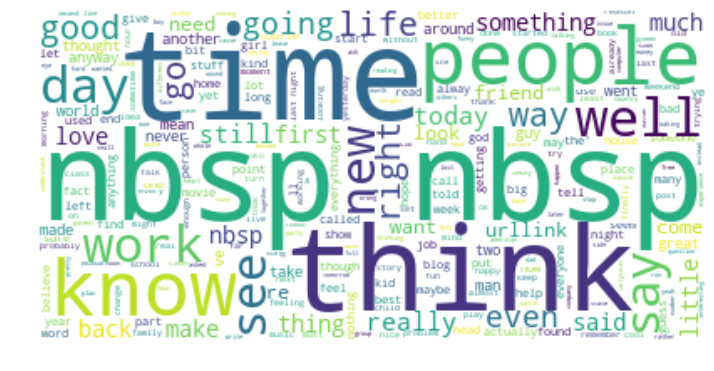

In [22]:
plt.figure(figsize=(12,12))
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
cloud=wordcloud.generate(str(text))
plt.axis("off")
plt.imshow(cloud, interpolation='bilinear')
#Why are nbsp and urllink here

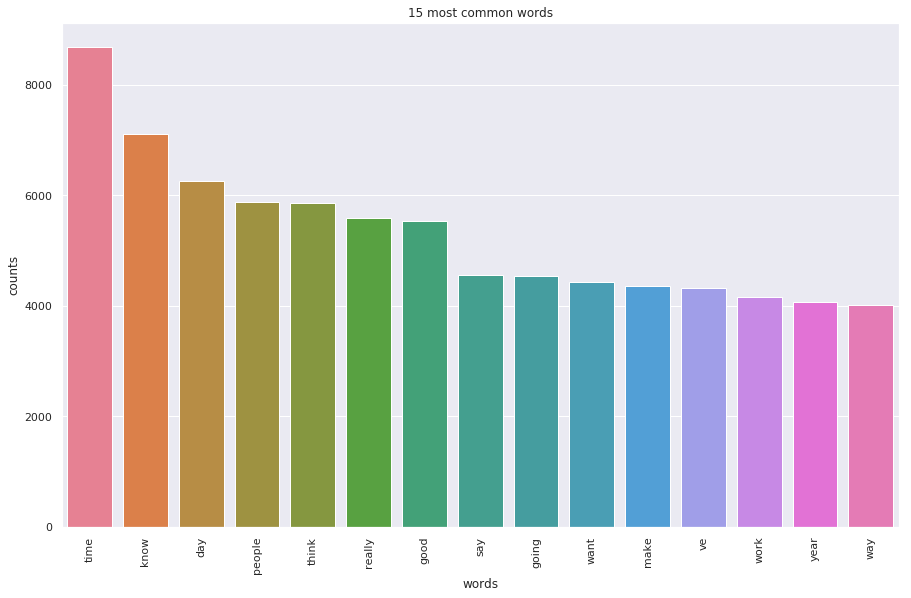

In [23]:
#Taken from Susan Li's Medium article.

from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline 
def plot_15_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:15]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='15 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(test['formattedstr'])# Visualise the 10 most common words
plot_15_most_common_words(count_data, count_vectorizer)
#"Got" should be a stopword. Should "like" be a stopword?

In [24]:
import gensim
dictionary = gensim.corpora.Dictionary(test['formatted'])
bow_corpus = [dictionary.doc2bow(doc) for doc in test['formatted']]

In [25]:
#Seeing what the bow_corpus looks like:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 7 (",") appears 5 time.
Word 9 (".") appears 1 time.
Word 102 ("home") appears 1 time.
Word 105 ("i") appears 1 time.
Word 136 ("morning") appears 1 time.
Word 295 ("7") appears 1 time.
Word 298 (":") appears 8 time.
Word 657 ("night") appears 1 time.
Word 868 ("we") appears 1 time.
Word 971 ("good") appears 1 time.
Word 1005 ("shop") appears 1 time.
Word 1024 ("went") appears 1 time.
Word 1427 ("came") appears 1 time.
Word 1597 ("pretty") appears 1 time.
Word 1701 ("exercise") appears 1 time.
Word 2019 ("left") appears 1 time.
Word 2025 ("sleep") appears 1 time.
Word 2051 ("c") appears 1 time.
Word 2083 ("6") appears 1 time.
Word 2230 ("b") appears 1 time.
Word 2928 ("&") appears 1 time.
Word 3127 ("level") appears 1 time.
Word 3246 ("pain") appears 2 time.
Word 3291 ("bread") appears 1 time.
Word 3311 ("energy") appears 2 time.
Word 3545 ("bedtime") appears 1 time.
Word 4668 ("ate") appears 1 time.
Word 4809 ("kept") appears 1 time.
Word 5300 ("cheese") appears 1 time.
Word 5332

In [26]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.013770274854253136),
 (1, 0.10443372953113302),
 (2, 0.0650558849610079),
 (3, 0.030496910155772126),
 (4, 0.016764648448097323),
 (5, 0.030783258194156546),
 (6, 0.05106254732024654),
 (7, 0.11041809374731523),
 (8, 0.08491784237919031),
 (9, 0.05234022938246519),
 (10, 0.05381306524700854),
 (11, 0.0706100848317896),
 (12, 0.05125787995397292),
 (13, 0.08143821795225331),
 (14, 0.06963824800718009),
 (15, 0.03403618578295801),
 (16, 0.07506870480716213),
 (17, 0.05868637181591673),
 (18, 0.04405920179478559),
 (19, 0.08143821795225331),
 (20, 0.041443675796235556),
 (21, 0.10443372953113302),
 (22, 0.06945749126080544),
 (23, 0.05099814740455994),
 (24, 0.04096306961485693),
 (25, 0.05333391764423958),
 (26, 0.07283236486309495),
 (27, 0.03576141182141137),
 (28, 0.03639739531011233),
 (29, 0.07166906354864223),
 (30, 0.02846098406351005),
 (31, 0.03750078732868527),
 (32, 0.048726426130822065),
 (33, 0.04629256694833177),
 (34, 0.032134001290046475),
 (35, 0.054143642195209),

In [27]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [28]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.065*"," + 0.046*"." + 0.014*"-" + 0.008*"'s" + 0.008*"the" + 0.007*":" + 0.005*"i" + 0.004*"'" + 0.004*"u" + 0.004*"'t"
Topic: 1 
Words: 0.047*"," + 0.040*"i" + 0.037*"." + 0.008*"'s" + 0.008*":" + 0.008*"'t" + 0.005*"?" + 0.004*"-" + 0.004*"know" + 0.004*"time"
Topic: 2 
Words: 0.074*"," + 0.069*"." + 0.040*"i" + 0.011*"'s" + 0.010*"'t" + 0.007*"?" + 0.005*"!" + 0.005*"time" + 0.005*"the" + 0.004*"get"
Topic: 3 
Words: 0.027*"," + 0.020*"!" + 0.017*"." + 0.010*"i" + 0.007*"..." + 0.007*"-" + 0.006*":" + 0.005*"=" + 0.005*"the" + 0.005*"'s"
Topic: 4 
Words: 0.080*"." + 0.072*"i" + 0.035*"," + 0.014*"'s" + 0.013*"'t" + 0.009*"'m" + 0.009*"!" + 0.007*"get" + 0.006*"time" + 0.006*"it"
Topic: 5 
Words: 0.073*"." + 0.058*"," + 0.046*"i" + 0.011*":" + 0.010*"'s" + 0.007*"the" + 0.006*"'m" + 0.004*"'t" + 0.004*"?" + 0.004*"it"
Topic: 6 
Words: 0.033*"..." + 0.031*"." + 0.026*".." + 0.022*"," + 0.016*"-" + 0.011*"'s" + 0.009*"i" + 0.009*"urllink" + 0.007*"!" + 0.006*":"
Topi

In [29]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.002*"i" + 0.001*"," + 0.001*"." + 0.001*"urllink" + 0.001*"-" + 0.001*"?" + 0.001*"'s" + 0.001*"..." + 0.001*"!" + 0.001*"'t"
Topic: 1 Word: 0.003*"i" + 0.002*"," + 0.002*"." + 0.001*"..." + 0.001*"'s" + 0.001*"-" + 0.001*"'t" + 0.001*"!" + 0.001*"'m" + 0.001*"?"
Topic: 2 Word: 0.002*"i" + 0.001*"," + 0.001*"." + 0.001*"..." + 0.001*"!" + 0.001*"'s" + 0.001*"'t" + 0.001*"'m" + 0.001*":" + 0.001*"?"
Topic: 3 Word: 0.002*"i" + 0.002*"," + 0.001*"." + 0.001*"'s" + 0.001*"..." + 0.001*"'t" + 0.001*"!" + 0.001*"?" + 0.001*":" + 0.001*"-"
Topic: 4 Word: 0.002*"i" + 0.002*"," + 0.001*"." + 0.001*"!" + 0.001*"'s" + 0.001*":" + 0.001*"..." + 0.001*"?" + 0.001*"'m" + 0.001*"-"
Topic: 5 Word: 0.001*"i" + 0.001*"," + 0.001*"!" + 0.001*"." + 0.001*"..." + 0.001*"'s" + 0.001*":" + 0.001*"'t" + 0.001*"?" + 0.000*"-"
Topic: 6 Word: 0.002*"i" + 0.001*"," + 0.001*"." + 0.001*"!" + 0.001*"'s" + 0.001*"..." + 0.001*"'t" + 0.001*"'m" + 0.001*"?" + 0.001*":"
Topic: 7 Word: 0.006*"i" + 0.004

# Trying Naive Bayes to Classify Blogposts
### First some preprocessing:

# Remember to build ROC/AUC
# Test bayesian models

In [30]:
from sklearn import preprocessing
# creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
# reviews.dropna(inplace=True)
label_encoded=le.fit_transform(test['topic'])

from sklearn.model_selection import train_test_split
X = test['formattedstr']
y = label_encoded
X_train, X_test, y_train, y_test = train_test_split(X,y)

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
#Metrics I'm going to use
from sklearn.metrics import f1_score, balanced_accuracy_score

In [31]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=.05)
clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
balanced_accuracy_score(y_test, y_preds)

0.15446114419529214

In [32]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(alpha = 0)
clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)
f1_score(y_test, y_preds, average='weighted')

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.15955476262516816

In [33]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_cv, y_train)
y_preds=clf.predict(X_test_cv)

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


TypeError: balanced_accuracy_score() got an unexpected keyword argument 'average'

In [34]:
balanced_accuracy_score(y_test, y_preds)

0.05

In [ ]:
import gensim
# let X be a list of tokenized texts (i.e. list of lists of tokens)
model = gensim.models.Word2Vec(X, size=300)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [ ]:
model.vocabulary